

# Laboratorio Modelos Generativos

## Introducción

En este laboratorio implementaremos un modelo de [Autoencoder Variacional](https://arxiv.org/abs/1312.6114), propuesto por Kingma y Welling, para la generación de imágenes. A lo largo de este ejercicio, construiremos este modelo paso a paso y analizaremos la importancia del espacio latente en el proceso de generación de imágenes. En su trabajo original, los autores utilizaron el conjunto de datos [MNIST](https://paperswithcode.com/dataset/mnist), ampliamente conocido en la comunidad de visión por computador, que consiste en imágenes de dígitos escritos a mano. Este dataset ha sido utilizado para diversas tareas, como la clasificación de imágenes, y en nuestro caso, para la generación de imágenes. Durante el laboratorio, se familiarizarán con el conjunto de datos MNIST, el tipo de imágenes que lo componen y su relevancia para este tipo de tareas.

### Librerías



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets 
from torch.utils.data import random_split, DataLoader
from sklearn.decomposition import PCA

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 128.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install torch-fidelity


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


### Base de datos

El conjunto de datos MNIST es una base de datos ampliamente utilizada en el campo del aprendizaje automático y la visión por computadora, específicamente para el reconocimiento de dígitos escritos a mano. Se compone de 70,000 imágenes en escala de grises de 28x28 píxeles, divididas en 10 clases que corresponden a los dígitos del 0 al 9. De estas, 60,000 imágenes son utilizadas para entrenamiento y 10,000 para pruebas.

Este conjunto de datos es fundamental en la investigación y desarrollo de algoritmos de clasificación de imágenes, ya que proporciona un entorno sencillo y estandarizado para evaluar el rendimiento de diferentes técnicas de aprendizaje. A diferencia de conjuntos de datos como CIFAR-10, que presenta imágenes más variadas y a color, MNIST se centra en un problema más específico, lo que permite a los investigadores probar rápidamente nuevos enfoques antes de aplicarlos a tareas más complejas.

Recopilado por Yann LeCun, Corinna Cortes y Christopher Burges, MNIST ha jugado un papel crucial en el desarrollo de redes neuronales, especialmente en los primeros experimentos con redes neuronales convolucionales (CNN). El conjunto de datos ha sido un punto de referencia esencial para medir el desempeño de modelos en tareas de clasificación de imágenes.

Para más información sobre este conjunto de datos, puede visitar la base de datos [MNIST](https://paperswithcode.com/dataset/mnist)

In [4]:
# Se descargan los datos del dataset se MNIST usando el modulo datasets de la librería torch. Estos quedan almacenados dentro de 
# la carpeta 'data/MNIST/raw'
# Se guardan estos datos en la variable mnist_data. El parametro transform es utilizado para 
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

Una vez descargado el conjunto de datos MNIST, procederemos a explorarlo. Primero, los datos obtenidos corresponden al conjunto de entrenamiento que utilizaremos para entrenar nuestro modelo. A continuación, examinaremos las imágenes y sus respectivas anotaciones. Como se puede observar, las imágenes presentan un fondo negro con un dígito manuscrito en color blanco. La etiqueta asociada a cada imagen corresponde al dígito representado, lo que facilita la tarea de clasificación.

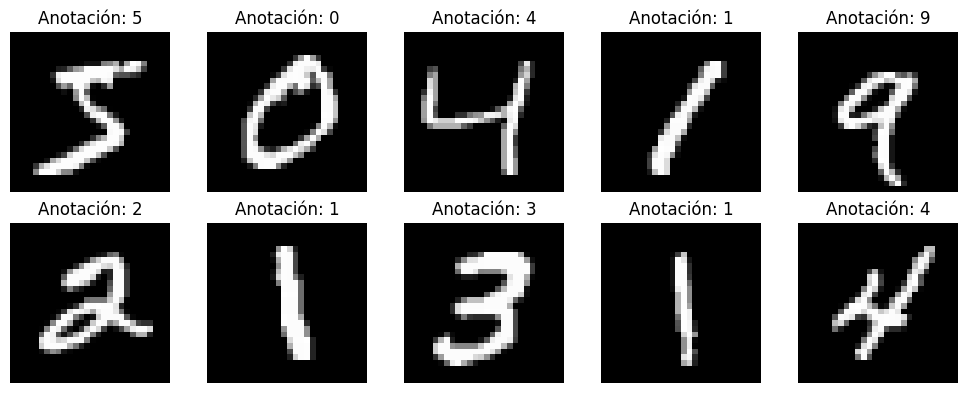

In [5]:
# Obtener un lote de imágenes y etiquetas
imagenes, anotaciones = zip(*[(mnist_data[i][0], mnist_data[i][1]) for i in range(10)])  # Obtener las primeras 10 imágenes y sus anotaciones

# Crear un gráfico
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Crear una cuadrícula de 2 filas y 5 columnas
    plt.imshow(imagenes[i].squeeze(), cmap='gray')  # Mostrar la imagen
    plt.title(f'Anotación: {anotaciones[i]}')  # Mostrar la etiqueta
    plt.axis('off')  # Quitar los ejes

plt.tight_layout()
plt.show()

## Autoencoder Variacional

Un **Autoencoder Variacional (VAE)** es un tipo de red neuronal diseñado para realizar **aprendizaje no supervisado** con el objetivo de generar nuevas muestras similares a las de un conjunto de datos de entrenamiento. A diferencia de un autoencoder clásico, que simplemente comprime y descomprime los datos, un VAE modela una **distribución probabilística** sobre el espacio latente, lo que permite generar muestras nuevas.

### 1. Encoder: Mapear el espacio de entrada al espacio latente

El encoder de un VAE toma una entrada $x$ y la mapea a un **espacio latente** $z$. Sin embargo, en lugar de producir un punto fijo en este espacio, el encoder genera una **distribución probabilística** sobre $z$. Esta distribución está caracterizada por dos parámetros:

- **Media** $\mu$
- **Logaritmo de la varianza** $\log \sigma^2$ (esto se utiliza en lugar de la varianza directa para mayor estabilidad numérica).

Para una entrada $x$, el encoder produce:

$$
\mu = \text{encoder}_\mu(x)
$$

$$
\log \sigma^2 = \text{encoder}_{\log \sigma^2}(x)
$$

En el código, estas son las capas `fc_mu` y `fc_logvar`.

### 2. Reparametrización del espacio latente

El VAE introduce un truco de reparametrización para permitir el entrenamiento mediante gradientes. En lugar de directamente muestrear de una distribución normal $N(\mu, \sigma^2)$, el muestreo se realiza usando una variable auxiliar $\epsilon$ proveniente de una **distribución normal estándar** $N(0, 1)$:

$$
z = \mu + \sigma \cdot \epsilon
$$

Donde:

$$
\sigma = \exp \left( \frac{1}{2} \log \sigma^2 \right)
$$

Este truco asegura que $z$ siga una distribución $N(\mu, \sigma^2)$ sin romper la diferenciabilidad requerida para el entrenamiento con gradientes. Aquí, $\epsilon$ es ruido gaussiano muestreado como:

$$
\epsilon \sim N(0, 1)
$$

En el código, este paso se realiza con la siguiente línea:

```python
z = mu + torch.exp(0.5 * logvar) * epsilon
```

### 3. Decoder: Reconstrucción de la entrada

Una vez obtenida una muestra del espacio latente $z$, se utiliza el **decoder** para mapearla de vuelta al espacio de entrada, produciendo una reconstrucción $\hat{x}$. El decoder toma $z$ como entrada y genera la salida reconstruida $\hat{x}$:

$$
\hat{x} = \text{decoder}(z)
$$

El decoder en el código corresponde a las capas `decoder_fc` y `output_fc`, con la función de activación `sigmoid` en la salida para que los valores de la imagen reconstruida estén entre 0 y 1.

### 4. Función de pérdida del VAE

El VAE tiene una función de pérdida especial que combina dos términos:

### 4.1 Pérdida de reconstrucción (reconstruction loss)

Este término mide qué tan cerca está la imagen reconstruida $\hat{x}$ de la imagen original $x$. Generalmente, se utiliza la **entropía cruzada binaria** o el **error cuadrático medio** para esto:

$$
\mathcal{L}_{\text{rec}}(x, \hat{x}) = - \mathbb{E}_{q(z|x)} \left[ \log p(x|z) \right]
$$

### 4.2 Divergencia Kullback-Leibler (KL-divergence loss)

Este término fuerza la distribución $q(z|x)$ a acercarse a una **distribución normal estándar** $N(0, 1)$. La divergencia KL entre la distribución aproximada $q(z|x)$ y la distribución priori $p(z)$ es:

$$
\mathcal{L}_{\text{KL}}(q(z|x) \| p(z)) = -\frac{1}{2} \sum_{i=1}^{d} \left( 1 + \log (\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)
$$

Este término actúa como una regularización que empuja a la red a aprender un espacio latente organizado.

# Código explicativo
En primer lugar se establecen semillas para garantizar la reproducibilidad del código.

In [6]:
np.random.seed(42)         
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Modelo de Autoencoder Variacional (VAE)
Un autoencoder variacional (VAE) es un modelo generativo que aprende a comprimir datos (como imágenes) a una representación compacta en un espacio latente, permitiendo luego reconstruirlas. La característica que distingue al VAE de los autoencoders tradicionales es su enfoque probabilístico: en lugar de transformar los datos a un punto único en el espacio latente, el VAE aprende distribuciones que permiten muestrear diferentes versiones de los datos. Esta capacidad de generar nuevas muestras similares hace que los VAE sean muy útiles en tareas de generación de imágenes.

### Encoder: Mapeo al Espacio Latente
La arquitectura comienza con un encoder que convierte la imagen de entrada en una representación más compacta. Esta parte del modelo toma los datos originales (una imagen aplanada) y los transforma en una representación intermedia utilizando una capa fully connected (lineal) y una activación ReLU. Luego, a partir de esta representación intermedia, se calculan dos parámetros clave: la media (`mu`) y el logaritmo de la varianza (`logvar`). Estos parámetros definen la distribución Gaussiana en el espacio latente para cada muestra de entrada. La media indica el centro de la distribución, mientras que el logaritmo de la varianza mejora la estabilidad numérica al evitar valores negativos para la varianza.

### Reparametrización: Muestreo Latente
El VAE utiliza un proceso llamado reparametrización para asegurar que el muestreo del espacio latente sea compatible con la retropropagación durante el entrenamiento. En lugar de muestrear directamente de la distribución Gaussiana definida por mu y logvar, el modelo genera un ruido aleatorio $\epsilon$ del mismo tamaño que logvar. Luego, el espacio latente se obtiene mediante la fórmula:
$$
z = \mu + \sigma \cdot \epsilon, \text{ donde } \sigma = exp(0.5 \cdot log(var))
$$

Este truco permite que el modelo entrene eficazmente, ya que el espacio latente sigue una distribución normal, pero conserva las propiedades estocásticas necesarias para la generación de datos.

### Decoder: Reconstrucción de Imágenes
La segunda parte del modelo es el decoder, que toma las muestras latentes generadas y las transforma nuevamente al espacio de entrada, es decir, reconstruye las imágenes originales. La variable latente `z` se pasa por una capa lineal seguida de una activación ReLU, obteniendo así una representación intermedia. Posteriormente, otra capa lineal transforma esta representación en una imagen reconstruida, y se aplica una función sigmoide en la salida para garantizar que los valores de los píxeles estén entre 0 y 1. Este proceso permite al modelo recrear las imágenes basándose en la información almacenada en la distribución latente.

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super().__init__()

        # -- Encoder --
        # Primera capa fully connected del encoder. Convierte la imagen de entrada en una representación más compacta (hidden dimension)
        self.encoder_fc = nn.Linear(input_dim, hidden_dim)

        # Capa para calcular el valor medio (mu) del espacio latente. Esta capa toma la representación intermedia y produce 
        # la media de la distribución latente.
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)

        # Capa para calcular el logaritmo de la varianza (logvar) del espacio latente. 
        # Produce la varianza en forma logarítmica para mayor estabilidad numérica.
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # -- Decoder --
        # Primera capa fully connected del decodificador. Convierte la representación latente en una representación intermedia.
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)

        # Capa de salida del decodificador. Convierte la representación intermedia en una imagen de salida reconstruida (espacio de pixeles)
        self.output_fc = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """
        Función de codificación:
        Convierte las imágenes de entrada en las variables latentes mu (media) y logvar (logaritmo de la varianza)
        """
        # Paso 1: Pasar la imagen a través de la capa fully connected y aplicar la función de activación ReLU
        h = F.relu(self.encoder_fc(x))

        # Paso 2: Calcular la media (mu) del espacio latente
        mu = self.fc_mu(h)

        # Paso 3: Calcular el logaritmo de la varianza (logvar) del espacio latente
        logvar = self.fc_logvar(h)

        # Retornar mu y logvar, que describen la distribución latente
        return mu, logvar

    def decode(self, z):
        """
        Función de decodificación:
        Reconstruye las imágenes a partir de las variables latentes (z)
        """
        # Paso 1: Pasar la variable latente a través de la capa fully connected y aplicar la función de activación ReLU
        h_decoded = F.relu(self.decoder_fc(z))

        # Paso 2: Reconstruir la imagen de salida a partir de la capa de salida y aplicar la función sigmoide para obtener valores entre 0 y 1
        x_reconstructed = torch.sigmoid(self.output_fc(h_decoded))

        # Retornar la imagen reconstruida
        return x_reconstructed

    def forward(self, x):
        """
        Forward pass:
        Este método realiza la codificación, la reparametrización y la decodificación.
        """
        # Paso 1: Codificar la imagen de entrada para obtener mu y logvar
        mu, logvar = self.encode(x)

        # Paso 2: Usar el truco de reparametrización para obtener una muestra del espacio latente
        # Generamos un ruido aleatorio (epsilon) del mismo tamaño que logvar
        epsilon = torch.randn_like(logvar)

        # Reparametrización: z = mu + sigma * epsilon, donde sigma = exp(0.5 * logvar)
        # Esto garantiza que z sea una muestra de la distribución latente
        z = mu + logvar * epsilon

        # Paso 3: Decodificar la variable latente z para reconstruir la imagen
        x_reconstructed = self.decode(z)

        # Retornar la imagen reconstruida, junto con mu y logvar para calcular la pérdida de VAE
        return x_reconstructed, mu, logvar

Se definen los parámetros necesarios para entrenar el modelo, incluyendo tanto los hiperparámetros como la tasa de aprendizaje, la dimensión de entrada, y la del espacio latente. Además, se especifican el número de épocas y el tamaño de los lotes (batch). Los datos se dividen en dos conjuntos: uno para entrenamiento y otro para prueba, asignando el 90% de las muestras al entrenamiento y el 10% restante a la evaluación del modelo. 

**Importante**: en esta celda pueden ajustar los parámetros del entrenamiento para mejorar el desempeño del VAE. No deben modificar el device ni la división en train y test.

In [22]:
INPUT_DIM = 784  # Dimensión de entrada: MNIST tiene imágenes de 28x28 píxeles (28 * 28 = 784).
Z_DIM = 6  # Dimensión del espacio latente: El tamaño del vector latente que representará las características más relevantes de la imagen.
H_DIM = 512  # Tamaño de la capa oculta: La dimensión de la capa intermedia utilizada en el encoder y decoder.
NUM_EPOCHS = 10  # Número de épocas: Cada época implica recorrer todo el dataset una vez durante el entrenamiento.
BATCH_SIZE = 64  # Tamaño del batch: Número de muestras procesadas simultáneamente en cada paso del entrenamiento.
LR_RATE = 1e-3  # Tasa de aprendizaje: Define la magnitud de los ajustes que realiza el optimizador en cada paso.


In [23]:
# Definimos los parámetros para llevar a cabo el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# Selección del dispositivo: Si una GPU está disponible, se usará para acelerar el proceso. 
# Si no, se utilizará la CPU.

# Creamos divisiones del dataset MNIST en conjuntos de entrenamiento y prueba (validación).
train_size = int(0.9 * len(mnist_data))  # Usamos el 90% de los datos para entrenamiento.
test_size = int(0.1 * len(mnist_data))   # Usamos el 10% restante para prueba.
train_dataset, test_dataset = random_split(mnist_data, [train_size, test_size])  
# Se usa `random_split` para dividir aleatoriamente el dataset según las proporciones definidas.

# Inicializamos los DataLoaders para cargar los datos en lotes durante el entrenamiento y la prueba.
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# El DataLoader de entrenamiento cargará los datos en lotes de tamaño BATCH_SIZE y los barajará antes de cada época para evitar sobreajustes.

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
# El DataLoader de prueba cargará un solo dato por lote (batch_size=1), también con barajado.
# Esto nos permitirá evaluar cada muestra individualmente durante la inferencia o validación.

La función `train` implementa el ciclo de entrenamiento de un modelo, ejecutándose durante un número definido de épocas (`num_epochs`). En cada época, se recorre el conjunto de datos mediante lotes (batches) proporcionados por el `data_loader`. Para cada lote, las imágenes se transfieren al dispositivo de cálculo adecuado (GPU) y se aplanan a un vector de dimensión 784 (28x28 píxeles). Luego, las imágenes pasan por el modelo, que genera la reconstrucción de las mismas (`x_reconst`), junto con la media (`mu`) y la desviación estándar (`sigma`) de las variables en el espacio latente. 

A continuación, se calcula la función de pérdida compuesta por dos términos: la pérdida de reconstrucción, que mide la diferencia entre las imágenes originales y las reconstruidas, y la divergencia KL, que penaliza las desviaciones de las variables latentes respecto a una distribución gaussiana estándar. La suma de ambas pérdidas constituye la pérdida total. 

Posteriormente, se realiza la optimización mediante backpropagation. Para ello, los gradientes del optimizador se reinician con `zero_grad` para evitar acumulación, y luego se calculan los gradientes con `backward` a partir de la pérdida total. Finalmente, los pesos del modelo se actualizan utilizando el optimizador mediante el método `step`. Esta función asegura que el modelo mejore su capacidad para reconstruir las imágenes a lo largo de las épocas, ajustando sus parámetros para minimizar la pérdida total.

In [24]:
# Definimos el ciclo de entrenamiento
def train(num_epochs, model, optimizer, loss_fn, data_loader):
    # Iniciamos el ciclo de entrenamiento que se ejecutará durante el número de épocas definido
    for epoch in range(num_epochs):
        # `tqdm` proporciona una barra de progreso que muestra el estado y la velocidad del entrenamiento.
        loop = tqdm(enumerate(data_loader))  
        
        # Iteramos sobre los lotes (batches) de datos entregados por el `data_loader`.
        for i, (x, y) in loop:  
            # Forward pass:
            # Enviamos las imágenes al dispositivo adecuado (GPU si está disponible) y las aplanamos de 28x28 a 784.
            x = x.to(device).view(-1, INPUT_DIM)  

            # Pasamos los datos por el modelo. El modelo devuelve:
            # - `x_reconst`: La imagen reconstruida por el decodificador.
            # - `mu`: La media del espacio latente.
            # - `sigma`: La desviación estándar en el espacio latente.
            x_reconst, mu, sigma = model(x)  

            # Cálculo de la función de pérdida:
            # 1. Pérdida de reconstrucción: Calcula la diferencia entre la imagen original y la reconstruida.
            reconst_loss = loss_fn(x_reconst, x)  
            
            # 2. Divergencia KL: Penaliza las desviaciones de las variables latentes (mu y sigma) 
            # respecto a una distribución gaussiana estándar.
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))  

            # Cálculo de la pérdida total:
            # La pérdida final es la suma de la pérdida de reconstrucción y la divergencia KL.
            loss = reconst_loss + kl_div  

            # Backpropagation y optimización:
            # Reseteamos los gradientes acumulados para evitar que se sumen a los de iteraciones previas.
            optimizer.zero_grad()  
            # Realizamos la retropropagación para calcular los gradientes de la pérdida respecto a los pesos del modelo.
            loss.backward()  
            # Actualizamos los pesos del modelo utilizando el optimizador.
            optimizer.step()  


Con el código previamente implementado, se procede a inicializar el modelo, configurar el optimizador y definir la función de pérdida. Con estos elementos listos, se invoca la función de entrenamiento para llevar a cabo el proceso de aprendizaje del modelo.

**Importante**: en la siguiente celda pueden ajustra el optimizador o la función de pérdida para mejorar el rendimiento del modelo.

In [25]:
# Inicializamos el modelo, el optimizador y la función de pérdida
model = VariationalAutoEncoder(INPUT_DIM, Z_DIM).to(device)  
# Creamos una instancia del modelo de Autoencoder Variacional (VAE), con la dimensión de entrada (INPUT_DIM) y la dimensión latente (Z_DIM), y lo enviamos al dispositivo (GPU o CPU)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)  
# Definimos el optimizador Adam, que actualizará los parámetros del modelo. La tasa de aprendizaje está definida por LR_RATE

loss_fn = nn.BCELoss(reduction="sum")  
# Definimos la función de pérdida, en este caso Binary Cross-Entropy (BCE), que mide la diferencia entre la salida reconstruida y la imagen original. 

# Ejecutamos el entrenamiento
train(NUM_EPOCHS, model, optimizer, loss_fn, train_loader)  
# Llamamos a la función `train`, pasando el número de épocas, el modelo, el optimizador y la función de pérdida. Esto ejecuta el ciclo de entrenamiento del modelo

844it [00:05, 140.68it/s]
844it [00:06, 138.83it/s]
844it [00:05, 144.54it/s]
844it [00:05, 143.09it/s]
844it [00:05, 143.19it/s]
844it [00:05, 141.62it/s]
844it [00:05, 142.22it/s]
844it [00:06, 138.29it/s]
844it [00:05, 141.48it/s]
844it [00:06, 138.52it/s]


La función de inferencia tiene como objetivo generar imágenes sintéticas de un dígito específico utilizando un modelo previamente entrenado. En primer lugar, recorre los datos de prueba (del dataset MNIST) para seleccionar una imagen representativa de cada dígito del 0 al 9. Una vez recopiladas estas imágenes, el modelo las codifica en su espacio latente, obteniendo para cada una la media (`mu`) y la desviación estándar (`sigma`) correspondientes.

Para generar la imagen sintética del dígito solicitado, la función aplica el proceso de reparametrización. En este paso, se toma una muestra aleatoria de una distribución normal estándar (`epsilon`), que luego se combina con los parámetros latentes (`mu` y `sigma`) para construir un vector latente `z`. Este vector se pasa a través del decodificador del modelo, produciendo una imagen generada. Finalmente, la imagen se reformatea a su tamaño original (28x28 píxeles) y se devuelve junto con la imagen real correspondiente del dígito, permitiendo comparar el resultado sintético con su contraparte del dataset.


In [26]:
# Definimos la función de inferencia, que genera imágenes sintéticas de un dígito determinado
def inferencia(digit, inference_data = test_dataset):
    # Lista para almacenar las imágenes de ejemplo de cada dígito
    images = []
    # Inicializamos el índice en 0, que representa el dígito actual que estamos buscando
    idx = 0
    # Iteramos sobre los datos de prueba del dataset MNIST
    for x, y in inference_data:
        # Si la etiqueta de la imagen (y) coincide con el índice (es decir, encontramos una imagen del dígito actual)
        if y == idx:
            # Añadimos la imagen a la lista `images`
            images.append(x)
            # Incrementamos el índice para buscar la siguiente imagen del siguiente dígito
            idx += 1
        # Si hemos recopilado una imagen de cada uno de los 10 dígitos (0 al 9), salimos del bucle
        if idx == 10:
            break
    
    # Lista para almacenar los pares (media, desviación estándar) de las codificaciones para cada dígito
    encodings_digit = []
    # Iteramos sobre los 10 dígitos (0 al 9)
    for d in range(10):
        # Desactivamos el cálculo de gradientes porque estamos en modo de inferencia (no entrenamiento)
        with torch.no_grad():
            # Codificamos la imagen del dígito actual usando el modelo, obteniendo la media (mu) y la desviación estándar (sigma)
            mu, sigma = model.encode(images[d].view(1, 784).to(device))
        # Añadimos el par (mu, sigma) de la codificación a la lista `encodings_digit`
        encodings_digit.append((mu, sigma))

    # Recuperamos la media (mu) y la desviación estándar (sigma) correspondientes al dígito especificado en `digit`
    mu, sigma = encodings_digit[digit]

    # Generamos una variable aleatoria epsilon con la misma forma que sigma, tomada de una distribución normal estándar
    epsilon = torch.randn_like(sigma)
    # Calculamos el vector latente `z` usando la reparametrización: z = mu + sigma * epsilon
    z = mu + sigma * epsilon
    # Decodificamos `z` usando el modelo para generar una imagen 
    out = model.decode(z)
    # Reformateamos la salida a la forma original de la imagen (1, 28, 28), que es una imagen de 28x28 píxeles con un solo canal (escala de grises)
    out = out.view(-1, 28, 28)

    image_gt = images[digit]

    return out, image_gt

##  Evaluación del modelo

La evaluación de modelos generativos, como los Autoencoders Variacionales (VAE), se centra en medir la calidad y realismo de las muestras generadas en comparación con los datos reales. Entre las métricas más utilizadas se encuentra la Frechet Inception Distance ([FID](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)), que evalúa la similitud entre la distribución de imágenes generadas y la distribución de imágenes reales. La FID calcula la distancia entre las distribuciones de las características intermedias de ambas imágenes, obtenidas de una red preentrenada (como InceptionV3). Para hacerlo, se genera un conjunto de imágenes sintéticas con el modelo y se extraen sus características, luego se calcula la media y la covarianza de estas características y se compara con las de las imágenes reales. La fórmula para FID entre las distribuciones de imágenes reales y generadas (caracterizadas por sus medias y covarianzas \($\mu_r$, $\Sigma_r$\) y \($\mu_g$, $\Sigma_g$\), respectivamente) es:

$$
\text{FID} = || \mu_r - \mu_g ||^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}).
$$

Un valor FID bajo indica que las imágenes generadas están más cerca de las reales, en términos de calidad visual y diversidad. Entre sus ventajas, la FID considera no solo la calidad de cada imagen individual, sino también la diversidad global, penalizando conjuntos de imágenes generadas que se desvíen de la variedad del conjunto real. Sin embargo, una de sus limitaciones es la sensibilidad a la arquitectura y parámetros de la red preentrenada utilizada para extraer características, lo que puede llevar a variabilidad en los resultados según el modelo de extracción.

Para evaluar nuestro modelo VAE vamos a utilizar la FID, utilizando la implementación disponible en Pytorch Lightning ([documentación oficial](https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html)). Para calcular la FID, generaremos 100 imágenes (10 de cada dígito) y las compararemos con 100 imágenes originales del conjunto de prueba, también distribuidas en 10 por dígito. Es importante notar que las imágenes generadas con el VAE son de tamaño 28x28 y están en escala de grises, mientras que el modelo utilizado para calcular la FID ([InceptionV3](https://pytorch.org/hub/pytorch_vision_inception_v3/)) requiere imágenes de tamaño 229x229 y en color (RGB). Por esta razón, aplicaremos un ajuste de tamaño y conversión a ambas, tanto a las imágenes originales como a las generadas, antes de calcular la FID.


In [27]:
list_generated_images = []
list_original_images = []

# Generamos y almacenamos 100 imágenes (10 por cada dígito)
for i in range(10):
    for _ in range(10):
        # inferencia(i) retorna una imagen generada y su correspondiente imagen de referencia (ground truth)
        generated_image, image_gt = inferencia(i)
        # Añadimos la imagen generada y la original a sus respectivas listas
        list_generated_images.append(generated_image)
        list_original_images.append(image_gt)

# Convertimos las listas de imágenes a tensores de PyTorch
tensor_generated_images = torch.stack(list_generated_images)
tensor_original_images = torch.stack(list_original_images)

# Paso 1: Convertimos las imágenes de escala de grises a RGB duplicando los canales
tensor_generated_images = tensor_generated_images.repeat(1, 3, 1, 1)  # Dimensiones ahora son (100, 3, 28, 28)

# Paso 2: Redimensionamos las imágenes a 229x229 utilizando interpolación bilineal
tensor_generated_images = F.interpolate(tensor_generated_images, size=(229, 229), mode='bilinear', align_corners=False)

# Convertimos el rango de valores de las imágenes generadas a enteros de 8 bits (0–255)
tensor_generated_images = (tensor_generated_images * 255).to(torch.uint8)

# Proceso análogo para el tensor con las imágenes originales o de referencia

# Paso 1: Convertimos las imágenes de escala de grises a RGB duplicando los canales
tensor_original_images = tensor_original_images.repeat(1, 3, 1, 1)  # Dimensiones ahora son (100, 3, 28, 28)

# Paso 2: Redimensionamos las imágenes a 229x229 utilizando interpolación bilineal
tensor_original_images = F.interpolate(tensor_original_images, size=(229, 229), mode='bilinear', align_corners=False)

# Convertimos el rango de valores de las imágenes originales a enteros de 8 bits (0–255)
tensor_original_images = (tensor_original_images * 255).to(torch.uint8)


In [28]:
from torchmetrics.image.fid import FrechetInceptionDistance  # Importamos la métrica de FID desde torchmetrics

# Creamos una instancia de la métrica FID especificando la capa de características de InceptionV3 que queremos usar.
# La opción `feature=192` selecciona una capa intermedia específica de la red InceptionV3 para extraer las características.
fid = FrechetInceptionDistance(feature=192)

# Actualizamos el objeto de FID con las imágenes reales
# `tensor_original_images.to('cpu')` mueve las imágenes originales a la CPU, ya que TorchMetrics requiere que los datos estén en CPU.
# `real=True` indica que estas imágenes corresponden a los datos reales (de referencia).
fid.update(tensor_original_images.to('cpu'), real=True)

# Actualizamos el objeto de FID con las imágenes generadas
# `tensor_generated_images.to('cpu')` mueve las imágenes generadas a la CPU.
# `real=False` indica que estas imágenes corresponden a los datos generados por el modelo (no reales).
fid.update(tensor_generated_images.to('cpu'), real=False)

# Calculamos y mostramos el valor de FID
# `fid.compute()` calcula la Frechet Inception Distance entre las distribuciones de imágenes reales y generadas.
# `round(..., 4)` redondea el valor obtenido a cuatro decimales para mayor claridad al imprimir.
print(f'El FID obtenido es: {round(fid.compute().item(), 4)}')

# Guardamos el valor del FID en la variable `fid_value` para el calificador
fid_value = fid.compute().item()


El FID obtenido es: 1.1841


**IMPORTANTE** Antes de enviar el laboratorio debes asegurarte que el valor de FID sea menor a 2.2 para obtener el 100% de calificación.
